Environment and Libraries

In [1]:
#Libraries
import cv2
import os
import glob
import warnings
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from random import randint
from tqdm import tqdm

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from scipy.spatial.distance import directed_hausdorff

if False:
  # Google drive
  from google.colab import drive
  drive.mount('/content/drive')

  # WD for Data
  os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks')

  # GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  # TPU
  # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  # tf.config.experimental_connect_to_cluster(resolver)
  # # This is the TPU initialization code that has to be at the beginning.
  # tf.tpu.experimental.initialize_tpu_system(resolver)
  # print("All devices: ", tf.config.list_logical_devices('TPU'))

In [9]:
import nibabel as nib
import numpy as np

def find_unique_numbers(arr):
    unique_numbers = np.unique(arr)
    return unique_numbers


nii_img_scan = nib.load("D:/MRI - Tairawhiti (User POV)/nnUNet Data/multiclass_masks/msk_004.nii.gz")
nii_img_scan_aug = nib.load("D:/MRI - Tairawhiti (User POV)/nnUNet Data/multiclass_masks/msk_004_aug0.nii.gz")

scan_data = nii_img_scan.get_fdata()
scan_aug_data = nii_img_scan_aug.get_fdata()
print(scan_aug_data.shape)

# np.savetxt('scan.txt', scan_data[450,:,:,0], fmt="%d", delimiter=",")
# np.savetxt('scan_aug.txt', scan_aug_data[450,:,:,0], fmt="%d", delimiter=",")

scan_data = scan_data[450,:,:,0]
unique_numbers = find_unique_numbers(scan_data)
print('Not Augmented: ', unique_numbers)

scan_aug_data = scan_aug_data[450,:,:,0]
unique_numbers = find_unique_numbers(scan_aug_data)
print('Augmented: ', unique_numbers)

(581, 512, 512, 1)
Not Augmented:  [0. 1. 3.]
Augmented:  [0. 1. 2. 3.]


In [26]:
# paitent_id = segmasks_fnames[0]
import os 
scan_data_folders = ['1_AutoBind_WaterWATER_450_15A']
paitent_id = (scan_data_folders[0].split('_'))[-1]
scans_path = 'D:/MRI - Tairawhiti (User POV)'
segmasks = []
files = os.listdir(('{}/Raw NIFITI Segmentation Masks (3D Slicer Output)').format(scans_path))
for file in files:
    file_id = file.split('_')[-1]
    file_id = file_id.split('.')[0]
    if (file_id == paitent_id):
        segmasks.append(file)
print(segmasks)

['1_RR_fibula_15A.nii', '1_R_femur_15A.nii', '1_R_tibia_15A.nii']


Preprocessing Pipeline

------------------------------
Loading and preprocessing training data...
------------------------------
Patient Scan Data Folders Included in Run:  ['6_AutoBindWATER_650_9B']


Segmentation Mask:  6_RR_fibula_9B
Patient Scan Data:  6_AutoBindWATER_650_9B
AOI Slice Start:  745
AOI Slice End:  958
AOI Slice Range:  214


Scans Normalized! [0-1]
Masks Binarised! [0,1]


Training Scans Input Shape:  (1015, 512, 512, 1)
Training Masks Input Shape:  (1015, 512, 512, 1)
Conversion to NIfTI complete with shape:  (1015, 512, 512, 1)


Successfully Exported Preprocessed Data!
Regions of Interest for Segmentation:  ['FEMUR', 'FIBULA', 'TIBIA']
Number of Segmentation Classes:  3
(467, 289, 317, 0)
(958, 331, 363, 0)
AOI Slice Start (Final with Thresholding):  447
AOI Slice End (Final with Thresholding):  978
Final Training Scans Input Shape:  (531, 512, 512, 1)
Final Training Masks Input Shape:  (531, 512, 512, 1)


MSK Multiclass Mask Made Using ['FEMUR', 'FIBULA', 'TIBIA'], Saved To D:/MRI - Ta

c:\Users\GGPC\OneDrive\Desktop\Part 4 Project\Part4Project\preprocessing.py:78: RuntimeWarning: invalid value encountered in true_divide
  image2 = image2 / np.max(image2)


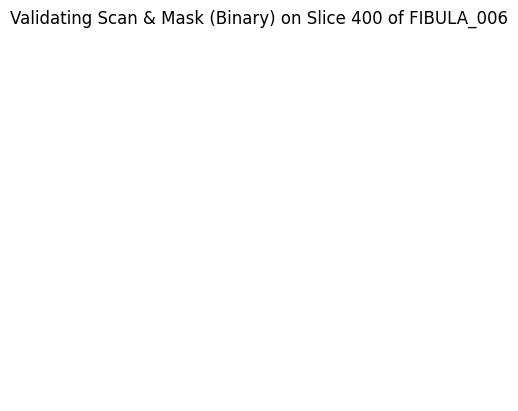

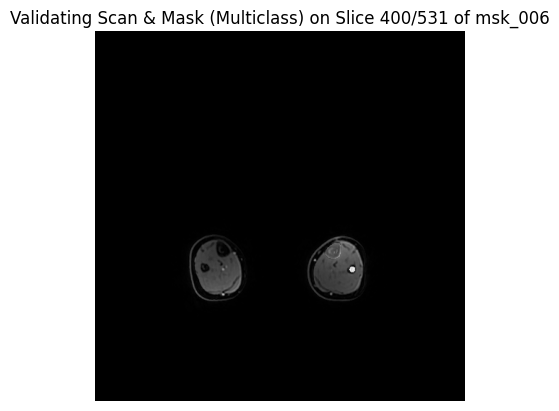

------------------------------
Completed Preprocessing Stage!
------------------------------


In [1]:
from preprocessing import preprocessing, VisualValidationMSK
from image_preprocessing import image_cropping, uniform_cropping, uniform_resizing
from writeout_dataset import Export2CompressedNifiti
from MSKMulticlass import CreateMasks4MulticlassMSK

print('-'*30)
print('Loading and preprocessing training data...')
print('-'*30)

# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
# \\files.auckland.ac.nz\research\resabi202200010-Friedlander
total_slices_raw_data = 200
DataOnlyAOI = False
ExportDatasets = True
Cropping = False
# Only set multiclassSegmentation to True once all the AOI masks are preprocessed or its onto the final AOI
multiclassSegmentation = True
scans_path = 'D:/MRI - Tairawhiti'

# segmasks_fnames = ['1_R_tibia_15A', '2_R_tibia_16A', '3_R_tibia_4A', '4_R_tibia_5A', '5_R_tibia_8A', '6_R_tibia_9B', '7_R_tibia_10B', '8_R_tibia_12A', '9_R_tibia_11A', '10_R_tibia_13A']
# segmasks_fnames = ['1_R_femur_15A', '2_R_femur_16A', '3_R_femur_4A', '4_R_femur_5A', '5_R_femur_8A', '6_R_femur_9B']
# segmasks_fnames = ['1_RR_fibula_15A', '2_RR_fibula_16A', '3_RR_fibula_4A', '4_RR_fibula_5A', '5_RR_fibula_8A', '6_RR_fibula_9B']
# scan_data_folders = ['1_AutoBind_WaterWATER_450_15A', '2_AutoBindWATER_450_16A', '3_AutoBindWATER_650_4A', '4_AutoBindWATER_750_5A', '5_AutoBindWATER_1050_8A', '6_AutoBindWATER_650_9B', '7_AutoBindWATER_450_10B',
#                     '8_AutoBindWATER_450_12A', '9_AutoBindWATER_550_11A', '10_AutoBindWATER_450_13A']

segmasks_fnames = ['6_RR_fibula_9B']
scan_data_folders = ['6_AutoBindWATER_650_9B']
colab_fname = ['FIBULA_006']

imgs_train, imgs_mask_train, median_aoi_index = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data, DataOnlyAOI)

if (Cropping == True):
    imgs_train, imgs_mask_train = image_cropping(imgs_train, top = 56, bottom = 56, left = 56, right = 56), image_cropping(imgs_mask_train, top = 56, bottom = 56, left = 56, right = 56)
    print("\n")
    print('Preprocessed Final Training Image Input Shape (After Image Preprocessing): ', imgs_train.shape)
    print('Preprocessed Final Training Mask Input Shape (After Image Preprocessing): ', imgs_mask_train.shape)

if (ExportDatasets == True):
    Export2CompressedNifiti(imgs_train, scans_path, colab_fname, imgs_mask_train)

if (multiclassSegmentation == True):
    # User Input
    individual_mask_directory = 'D:/MRI - Tairawhiti/nnUNet Data/masks'
    multiclass_mask_output_dir = 'D:/MRI - Tairawhiti/nnUNet Data/multiclass_masks'
    scan_dir = 'D:/MRI - Tairawhiti/nnUNet Data/scans'
    
    TIBIA_encoding = 1
    FEMUR_encoding = 2
    FIBULA_encoding = 3
    mask_index = int((colab_fname[0].split('_'))[1])
    AOIThresholding = True

    CreateMasks4MulticlassMSK(scan_dir, individual_mask_directory, mask_index, TIBIA_encoding, FEMUR_encoding, FIBULA_encoding, multiclass_mask_output_dir, AOIThresholding)


# Validate Scans & Masks (2D Slice)
if (multiclass_mask_output_dir != None):
    VisualValidationMSK(colab_fname, 400, 400, multiclass_mask_output_dir, mask_index)
else:
    VisualValidationMSK(colab_fname, 400, 400, False, mask_index)

print('-'*30)
print('Completed Preprocessing Stage!')
print('-'*30)

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from MSKMulticlass import CreateMasks4MulticlassMSK

def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def uniform_resizing(images, new_size):
    """
    Applies uniform resizing to an array of images. ### bicubic_interpolation

    Parameters:
        images (numpy.ndarray): Input array of images with shape (x, 512, 512, 1).
        new_size (tuple or int): The desired size of the resized images. If it's an int,
                                 the new size will be (new_size, new_size).

    Returns:
        numpy.ndarray: Array of resized images with shape (x, new_height, new_width, 1).
    """
    x, height, width, _ = images.shape

    if isinstance(new_size, int):
        new_height, new_width = new_size, new_size
    elif isinstance(new_size, tuple) and len(new_size) == 2:
        new_height, new_width = new_size
    else:
        raise ValueError("Invalid new_size argument. It should be an int or a tuple of two ints.")

    resized_images = np.zeros((x, new_height, new_width, 1))

    for i in range(x):
        resized_images[i, ..., 0] = resize(images[i, ..., 0], (new_height, new_width), mode='reflect', order=1)
        # resized_images[i, ..., 0] = resize(images[i, ..., 0], (new_height, new_width), mode='constant', preserve_range=True)

    return resized_images


scans_path = 'D:/MRI - Friedlander'


        

# slice = 750
# aoi = 'FEMUR'

# tibia_PLB_02 = nib.load(('{}/{}/{}/{}_001.nii.gz').format(scans_path, 'nnUNet Data/masks', aoi, aoi))
# tibia_PLB_02_data = tibia_PLB_02.get_fdata()
# print(tibia_PLB_02_data.shape)

# PLB_02 = nib.load(('{}/{}/msk_001.nii.gz').format(scans_path, 'nnUNet Data/scans'))
# PLB_02_data = PLB_02.get_fdata()
# # nii_img_mask = nib.Nifti1Image(PLB_02_data, affine=np.eye(4))
# # output_file_path = ('D:/MRI - Tairawhiti/PLB-02.nii.gz')
# # nib.save(nii_img_mask, output_file_path)   
# print(PLB_02_data.shape)

# image1 = PLB_02_data[:,slice,:]
# image2 = tibia_PLB_02_data[:,slice,:]
# superimposed_image = superimpose_images(image1, image2)


# plt.imshow(PLB_02_data[:,slice,:], cmap='gray')
# plt.axis('off')
# plt.show()

# plt.imshow(tibia_PLB_02_data[:,slice,:], cmap='gray')
# plt.axis('off')
# plt.show()

# plt.imshow(superimposed_image, cmap='gray')
# plt.axis('off')
# plt.show()


# PLB_02_data_512 = np.expand_dims(PLB_02_data, axis = -1)
# PLB_02_data_512 = PLB_02_data_512.transpose(1, 0, 2, 3)
# PLB_02_data_512 = uniform_resizing(PLB_02_data_512, 256)

# tibia_PLB_02_data_512 = np.expand_dims(tibia_PLB_02_data, axis = -1)
# tibia_PLB_02_data_512 = tibia_PLB_02_data_512.transpose(1, 0, 2, 3)
# tibia_PLB_02_data_512 = uniform_resizing(tibia_PLB_02_data_512, 256)

# plt.imshow(PLB_02_data_512[slice,:,:,0], cmap='gray')
# plt.axis('off')
# plt.show()

# plt.imshow(tibia_PLB_02_data_512[slice,:,:,0], cmap='gray')
# plt.axis('off')
# plt.show()

# superimposed_image = superimpose_images(PLB_02_data_512[slice,:,:,0], tibia_PLB_02_data_512[slice,:,:,0])

# plt.imshow(superimposed_image, cmap='gray')
# plt.axis('off')
# plt.show()

# nii_img_mask = nib.Nifti1Image(PLB_02_data_512, affine=np.eye(4))
# output_file_path = ('D:/MRI - Tairawhiti/PLB_02_data_512.nii.gz')
# nib.save(nii_img_mask, output_file_path)  

# nii_img_mask = nib.Nifti1Image(tibia_PLB_02_data_512, affine=np.eye(4))
# output_file_path = ('D:/MRI - Tairawhiti/tibia_PLB_02_data_512.nii.gz')
# nib.save(nii_img_mask, output_file_path)   

individual_mask_directory = ('{}/nnUNet Data/masks').format(scans_path)
multiclass_mask_output_dir = ('{}/nnUNet Data/multiclass_masks').format(scans_path)
scan_dir = ('{}/nnUNet Data/scans').format(scans_path)
mask_index = [1,2,3,4,5]

TIBIA_encoding = 1
FEMUR_encoding = 2
FIBULA_encoding = 3
PELVIS_encoding = 4
AOIThresholding = True
FriedLanderDataset = True

print('Multi-Class Segmentation Task Data Preparation!')

for i in range (len(mask_index)):
    CreateMasks4MulticlassMSK(scan_dir, individual_mask_directory, mask_index[i], TIBIA_encoding, FEMUR_encoding, FIBULA_encoding, PELVIS_encoding, multiclass_mask_output_dir, AOIThresholding, FriedLanderDataset)



Multi-Class Segmentation Task Data Preparation!
Regions of Interest for Segmentation:  ['FEMUR', 'FIBULA', 'PELVIS', 'TIBIA']
Number of Segmentation Classes:  4
(21, 160, 44, 0)
(854, 104, 177, 0)
AOI Slice Start (Final with Thresholding):  21
AOI Slice End (Final with Thresholding):  854
Final Training Scans Input Shape:  (833, 277, 230, 1)
Final Training Masks Input Shape:  (833, 277, 230, 1)


MSK Multiclass Mask Made Using ['FEMUR', 'FIBULA', 'PELVIS', 'TIBIA'], Saved To D:/MRI - Friedlander/nnUNet Data/multiclass_masks/msk_001.nii.gz, and Region of Interest Slice Thresholding = True !
Regions of Interest for Segmentation:  ['FEMUR', 'FIBULA', 'PELVIS', 'TIBIA']
Number of Segmentation Classes:  4
(30, 154, 51, 0)
(796, 115, 174, 0)
AOI Slice Start (Final with Thresholding):  30
AOI Slice End (Final with Thresholding):  796
Final Training Scans Input Shape:  (766, 260, 232, 1)
Final Training Masks Input Shape:  (766, 260, 232, 1)


MSK Multiclass Mask Made Using ['FEMUR', 'FIBULA', 

: 

In [4]:
PLB_02 = nib.load(('{}/{}/msk_001.nii.gz').format(scans_path, 'nnUNet Data/scans'))
PLB_02_data = PLB_02.get_fdata()

len(PLB_02_data.shape)

4

(457, 512, 512, 1)


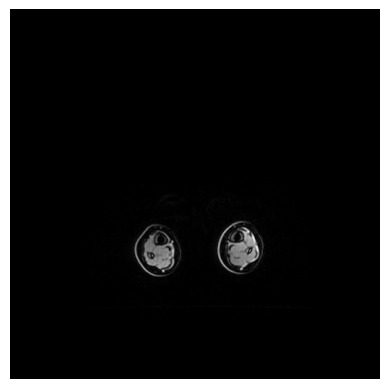

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image


slice_idx = 500

# nii_img_scan = nib.load('D:/MRI - Tairawhiti/nnUNet Data/scans/FEMUR_002.nii.gz')
# nii_img_mask = nib.load('D:/MRI - Tairawhiti/nnUNet Data/masks/FEMUR/FEMUR_002.nii.gz')
# mask_data = nii_img_mask.get_fdata()
# scan_data = nii_img_scan.get_fdata()

# image1 = scan_data[slice_idx, :, :, :]
# image2 = mask_data[slice_idx, :, :, :]
# superimposed_image = superimpose_images(image1, image2)
# plt.imshow(superimposed_image, cmap='gray')
# plt.axis('off')
# plt.show()

nii_img_mask = nib.load('D:/MRI - Tairawhiti (User POV)/nnUNet Data/scans/msk_001.nii.gz')
mask_data = nii_img_mask.get_fdata()
print(mask_data.shape)
image3 = mask_data[400, :, :, 0]
plt.imshow(image3, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def transform_string(input_string):
    parts = input_string.split('_')
    
    if len(parts) < 2:
        return None
    
    prefix = parts[-2].upper()
    
    try:
        number_part = int(parts[0])
    except ValueError:
        return None
    
    new_string = f'{prefix}_{number_part:03d}'
    return new_string

input_string = '20_RR_fibula_100C'
output_string = transform_string(input_string)
print(output_string)  # Output: 'FIBULA_006'


FIBULA_020


Aligning the Compressed Nifti Scans & Masks (Coordinate System, Direction)

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

fnames= ['Tibia_009', 'Tibia_010', 'Tibia_015']
translate_y = False
flip_direction = False

for fname in fnames:
    print(fname)
    
    nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/masks/{}.nii.gz').format(fname)
    nii_img = nib.load(nii_file_path)
    affine_matrix = nii_img.affine
    direction_mask = affine_matrix[:3, :3]
    origin_coordinates_mask = affine_matrix[:3, 3]
    # print("Mask Origin Coordinates:", origin_coordinates_mask)
    # print("Mask Direction Matrix:", direction)
    # print('\n')
    
    nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
    nii_img = nib.load(nii_file_path)
    affine_matrix = nii_img.affine
    direction_scan = affine_matrix[:3, :3]
    origin_coordinates_scan = affine_matrix[:3, 3]
    # print("Scan Origin Coordinates:", origin_coordinates)
    # print("Scan Direction Matrix:", direction)
    # print('\n')

    if (translate_y == True):
        nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
        nii_img = nib.load(nii_file_path)
        affine_matrix = nii_img.affine

        affine_matrix[:3, 3] = origin_coordinates_mask
        modified_nii_img = nib.Nifti1Image(nii_img.get_fdata(), affine_matrix)

        output_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
        nib.save(modified_nii_img, output_file_path)
        # print("Scan Origin coordinates modified and file rewritten!")

        nii_img = nib.load(nii_file_path)
        affine_matrix = nii_img.affine
        origin_coordinates_scan = affine_matrix[:3, 3]
        # print("Scan Origin Coordinates (Modified):", origin_coordinates)
        # print('\n')

    if (flip_direction == True):
        nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
        nii_img = nib.load(nii_file_path)
        direction = affine_matrix[:3, :3]

        affine_matrix[:3, :3] = direction_mask
        modified_nii_img = nib.Nifti1Image(nii_img.get_fdata(), affine_matrix)

        output_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
        nib.save(modified_nii_img, output_file_path)
        # print("Scan direction modified and file rewritten!")

        nii_img = nib.load(nii_file_path)
        affine_matrix = nii_img.affine
        direction_scan = affine_matrix[:3, :3]
        # print("Scan Direction (Modified):", direction_scan)
        # print('\n')


    target_orientation = ('R', 'A', 'S')
    nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
    nii_img = nib.load(nii_file_path)
    reoriented_img = nib.orientations.apply_orientation(nii_img, target_orientation)
    output_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname)
    nib.save(modified_nii_img, output_file_path)

    target_orientation = ('R', 'A', 'S')
    nii_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/masks/{}.nii.gz').format(fname)
    nii_img = nib.load(nii_file_path)
    reoriented_img = nib.orientations.apply_orientation(nii_img, target_orientation)
    output_file_path = ('D:/MRI - Tairawhiti/nnUNet Data/masks/{}.nii.gz').format(fname)
    nib.save(modified_nii_img, output_file_path)    

    if (np.array_equal(np.array(origin_coordinates_scan), np.array(origin_coordinates_mask)) == True):
        print(('Mask and Scan Coordinate Systems Matching! ({})').format(fname))
    else:
        print('ERROR: Mask and Scan Coordinate Systems Mismatch!')
    if (np.array_equal(np.array(direction_scan), np.array(direction_mask)) == True):
        print(('Mask and Scan Directions Matching! ({})').format(fname)) 
    else:
        print('ERROR: Mask and Scan Direction Mismatch!')
    print('\n')


    slice_idx = 100

    nii_img = nib.load(('D:/MRI - Tairawhiti/nnUNet Data/scans/{}.nii.gz').format(fname))
    nii_data = nii_img.get_fdata()
    plt.imshow(nii_data[:, :, slice_idx], cmap='gray')
    plt.title('Scan Slice Visualization')
    plt.colorbar()
    plt.show()

    nii_img = nib.load(('D:/MRI - Tairawhiti/nnUNet Data/masks/{}.nii.gz').format(fname))
    nii_data = nii_img.get_fdata()
    plt.imshow(nii_data[:, :, slice_idx], cmap='gray')
    plt.title('Mask Slice Visualization')
    plt.colorbar()
    plt.show()

Tibia_009


OrientationError: Data array has fewer dimensions than orientation

In [23]:
import os
import pydicom
import nibabel as nib
import numpy as np

fnames = ['3_AutoBindWATER_650_4A', '4_AutoBindWATER_750_5A', '5_AutoBindWATER_1050_8A', '6_AutoBindWATER_650_9B', '7_AutoBindWATER_450_10B']
dicom2nifiti = False
reverseMasksNifiti = True


if (dicom2nifiti == True):
    for fname in fnames:
        dicom_dir = ('D:/MRI - Tairawhiti/{}').format(fname)
        
        dicom_files = sorted([f for f in os.listdir(dicom_dir) if f.endswith('.dcm')])
        dicom_data = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in dicom_files]
        orientation = dicom_data[0].ImageOrientationPatient
        pixel_data = [d.pixel_array for d in dicom_data]

        volume = np.stack(pixel_data, axis=-1)

        nii_img = nib.Nifti1Image(volume, np.eye(4))

        orientation_matrix = np.array(orientation).reshape(2, 3)
        affine_matrix = np.eye(4)
        affine_matrix[:2, :3] = orientation_matrix

        nii_img.set_qform(affine_matrix)

        nii_output_path = ('D:/MRI - Tairawhiti/{}.nii.gz').format(fname)
        nib.save(nii_img, nii_output_path)

        print(("Conversion complete for {}!").format(fname))


if (reverseMasksNifiti == True):
    nii_dir = 'D:/MRI - Tairawhiti/nnUNet Data/masks'

    nii_files = sorted([f for f in os.listdir(nii_dir) if f.endswith('.nii.gz')])

    output_dir = 'D:/MRI - Tairawhiti/nnUNet Data/masks/idk'
    os.makedirs(output_dir, exist_ok=True)

    for nii_file in nii_files:
        nii_path = os.path.join(nii_dir, nii_file)
        nii_img = nib.load(nii_path)

        # Get the data array and reverse the order of elements
        nii_data = nii_img.get_fdata()
        reversed_data = np.flip(nii_data, axis=-1)

        # Create a new NIfTI image with the reversed data
        reversed_nii_img = nib.Nifti1Image(reversed_data, nii_img.affine)

        # Save the reversed NIfTI image
        reversed_output_path = os.path.join(output_dir, f"reversed_{nii_file}")
        nib.save(reversed_nii_img, reversed_output_path)

    print("Reversal within each NIfTI complete.")

Reversal within each NIfTI complete.


Superimposed Mask Visualisation 

0.0074625


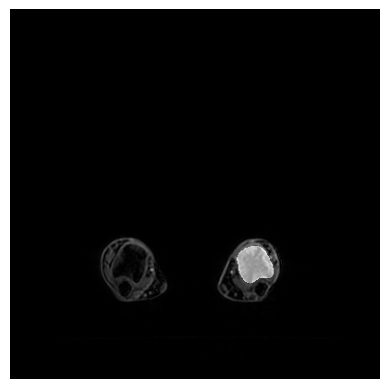

In [7]:
from preprocessing import preprocessing
import numpy as np
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

slice = 200
image1 = imgs_train[slice]
image2 = imgs_mask_train[slice]
superimposed_image = superimpose_images(image1, image2)
print(np.mean(image2))
plt.imshow(superimposed_image, cmap='gray')
plt.axis('off')
plt.show()

Data Augmentation

In [35]:
from data_augmentation import DataAugmentation

print('-'*30)
print('Data Augmentation Starting...')
print('-'*30)

num_augmentations = 3
augmented_images_train, augmented_masks_train = DataAugmentation(imgs_train, imgs_mask_train, num_augmentations)

augmented_images_train = np.expand_dims(augmented_images_train, axis=-1)
augmented_masks_train = np.expand_dims(augmented_masks_train, axis=-1)

print('Number of Augmentation per Input: ', num_augmentations)
print('\n')
print('Shape of Augmented Images: ', augmented_images_train.shape)
print('Shape of Augmented Masks: ', augmented_masks_train.shape)
print('\n')
print('Shape of Training Image Data (Before): ', imgs_train.shape)
print('Shape of Training Image Masks (Before): ', imgs_mask_train.shape)
print('\n')

if True:
    imgs_train = np.concatenate((imgs_train, augmented_images_train), axis=0)
    imgs_mask_train = np.concatenate((imgs_mask_train, augmented_masks_train), axis=0)

print('Shape of Training Image Data (After): ', imgs_train.shape)
print('Shape of Training Image Masks (After): ', imgs_mask_train.shape)

print('-'*30)
print('Completed Data Augmentation Stage!')
print('-'*30)

------------------------------
Data Augmentation Starting...
------------------------------


100%|██████████| 840/840 [00:12<00:00, 65.95it/s]


Number of Augmentation per Input:  3


Shape of Augmented Images:  (2520, 512, 512, 1)
Shape of Augmented Masks:  (2520, 512, 512, 1)


Shape of Training Image Data (Before):  (840, 512, 512, 1)
Shape of Training Image Masks (Before):  (840, 512, 512, 1)


Shape of Training Image Data (After):  (3360, 512, 512, 1)
Shape of Training Image Masks (After):  (3360, 512, 512, 1)
------------------------------
Completed Data Augmentation Stage!
------------------------------


Exporting out Labelled Datasets

In [1]:
# Exporting Training Scan and Mask Data
from writeout_dataset import WriteOutTextFile, WriteOutImagePNGFiles, ReadInDatasets, ReadInDatasetNPY

print('-'*30)
print('Exporting Scan & Mask Data...')
print('-'*30)

# starting_slice = 70
# save_directory_data_txt = 'D:/P4P Model Data/txt/Data_Tibia(Collab Sample)'
# WriteOutTextFile(imgs_train[:, :, :, 0], save_directory_data_txt, starting_slice)  
# save_directory_mask_txt = 'D:/P4P Model Data/txt/Mask_Tibia(Collab Sample)'
# WriteOutTextFile(imgs_mask_train[:, :, :, 0], save_directory_mask_txt, starting_slice)   

# np.save("D:/MRI - Tairawhiti/imgs_train_tibia.npy", imgs_train)
# np.save("D:/MRI - Tairawhiti/imgs_mask_train_tibia.npy", imgs_train)

imgs_train_scan_tibia = ReadInDatasetNPY('D:/MRI - Tairawhiti/Model Input Masks Tibia (Google Colab)')

print('-'*30)
print('Completed Exporting Stage!')
print('-'*30)

------------------------------
Exporting Scan & Mask Data...
------------------------------
------------------------------
Completed Exporting Stage!
------------------------------


2DUNet Model

In [26]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Dice Coefficient Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Adding a small constant to avoid division by zero
    print(y_true.shape)
    print(y_pred.shape)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    print(intersection)
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - tf.reduce_mean(dice_coefficient)
    return loss

2D Dense UNet

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout

def dense_block(x, filters, dropout_rate):
    conv1 = Conv2D(filters, 3, activation='relu', padding='same')(x)
    conv2 = Conv2D(filters, 3, activation='relu', padding='same')(conv1)
    concat = Concatenate(axis=-1)([x, conv2])
    if dropout_rate:
        concat = Dropout(dropout_rate)(concat)
    return concat

def dense_unet(input_shape, num_classes, filters=16, num_layers=4, dropout_rate=0.2):
    inputs = Input(input_shape)
    skip_connections = []

    # Downward path
    x = inputs
    for _ in range(num_layers):
        x = dense_block(x, filters, dropout_rate)
        skip_connections.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        filters *= 2

    # Bridge
    x = dense_block(x, filters, dropout_rate)

    # Upward path
    for i in range(num_layers):
        filters //= 2
        x = UpSampling2D(size=(2, 2))(x)
        x = Concatenate(axis=-1)([x, skip_connections.pop()])
        x = dense_block(x, filters, dropout_rate)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

H-DenseUNet

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        conv = Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = concatenate([x, conv], axis=-1)
    return x

def transition_down(x, filters):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def transition_up(x, filters):
    x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    return x

def h_dense_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Initial Convolution Block
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)

    # Downsample path
    down1 = dense_block(conv1, filters=64, num_layers=4)
    pool1 = transition_down(down1, filters=128)

    down2 = dense_block(pool1, filters=128, num_layers=4)
    pool2 = transition_down(down2, filters=256)

    down3 = dense_block(pool2, filters=256, num_layers=4)
    pool3 = transition_down(down3, filters=512)

    down4 = dense_block(pool3, filters=512, num_layers=4)

    # Upsample path
    up4 = transition_up(down4, filters=256)
    up4 = concatenate([up4, down3], axis=-1)
    up4 = dense_block(up4, filters=256, num_layers=4)

    up3 = transition_up(up4, filters=128)
    up3 = concatenate([up3, down2], axis=-1)
    up3 = dense_block(up3, filters=128, num_layers=4)

    up2 = transition_up(up3, filters=64)
    up2 = concatenate([up2, down1], axis=-1)
    up2 = dense_block(up2, filters=64, num_layers=4)

    # Output
    outputs = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(up2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

nnUNet

Importing Preprocessed Data

In [34]:
from writeout_dataset import ReadInDatasets, ReadInDatasetNPY

print('-'*30)
print('Importing Scan & Mask Data...')
print('-'*30)

# imgs_train = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Model Input Scans Tibia (Subset)')
# imgs_mask_train = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Model Input Masks Tibia (Subset)')

# imgs_train = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Model Input Scans Tibia (Subset)')
# imgs_mask_train = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Model Input Masks Tibia (Subset)')

imgs_train = ReadInDatasetNPY('D:/MRI - Tairawhiti/Model Input Scans Tibia (Subset)')
imgs_mask_train = ReadInDatasetNPY('D:/MRI - Tairawhiti/Model Input Masks Tibia (Subset)')

print('imgs_train size: ', imgs_train.shape)
print('imgs_mask_train size: ', imgs_mask_train.shape)

print('-'*30)
print('Importing Exporting Stage Completed!')
print('-'*30)

------------------------------
Importing Scan & Mask Data...
------------------------------
imgs_train size:  (214, 256, 256, 1)
imgs_mask_train size:  (214, 256, 256, 1)
------------------------------
Importing Exporting Stage Completed!
------------------------------


Training UNet

In [31]:
print('-'*30)
print('Training UNet Model...')
print('-'*30)

images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
print('Training Image Input Shape: ', images_train.shape)
print('Training Mask Input Shape: ', labels_train.shape)
print('Validation Image Input Shape: ', images_val.shape)
print('Validation Mask Input Shape: ', labels_val.shape)


print('-'*30)
print('Creating and compiling model...')
print('-'*30)

# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
#     tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
# ]

# input_shape = (256,256,1)
# model = unet_model(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy')
# # model.compile(optimizer='adam', loss=dice_loss)
# checkpoint = ModelCheckpoint('model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5', monitor='val_loss', save_best_only=True, mode='min')
# model.fit(x=images_train, y=labels_train, batch_size=4, epochs=20, validation_data=(images_val, labels_val), callbacks=[checkpoint])
# model.summary()

# Dense 2D UNet
# input_shape = (512,512,1)
# num_classes = 1
# model = dense_unet(input_shape, num_classes)
# model.compile(optimizer='adam', loss='binary_crossentropy')
# checkpoint = ModelCheckpoint('model(Baseline + 2D Dense Layers 125 Epoch).h5', monitor='val_loss', save_best_only=True, mode='min')
# model.fit(x=images_train, y=labels_train, batch_size=1, epochs=125, validation_data=(images_val, labels_val), callbacks=[checkpoint])
# model.summary()


# H-DenseUNet
input_shape = (400,400,1)
num_classes = 1
batch_size = 2
num_epochs = 10
model = h_dense_unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(images_train, labels_train, validation_data=(images_val, labels_val), batch_size=batch_size, epochs=num_epochs)
model.summary()

------------------------------
Training UNet Model...
------------------------------
Training Image Input Shape:  (168, 400, 400, 1)
Training Mask Input Shape:  (168, 400, 400, 1)
Validation Image Input Shape:  (42, 400, 400, 1)
Validation Mask Input Shape:  (42, 400, 400, 1)
------------------------------
Creating and compiling model...
------------------------------
Epoch 1/10


Prediction Mask

imgs_test size (Scans):  (214, 400, 400, 1)
imgs_test_masks size (Masks):  (214, 400, 400, 1)
------------------------------
Prediction Made Using Weights From Model: D:/MRI - Tairawhiti/Trained Models/model(2D-UNet, 3 Patients, Tibia, 400x400x1, 60 epoches).h5
------------------------------
1/1 [==============================] - 3s 3s/step
Testing Image Input Shape:  (400, 400, 1)


Dice Similarity Coefficient (DSC) Metric Value for Specified Slice:  [0.15360412]


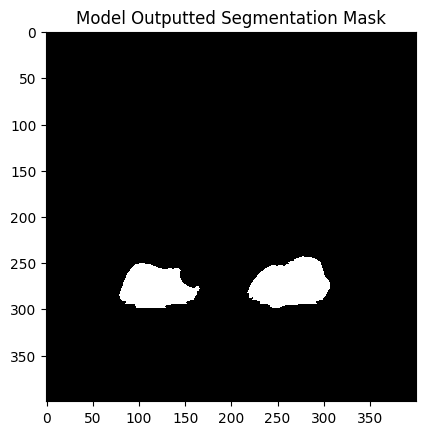

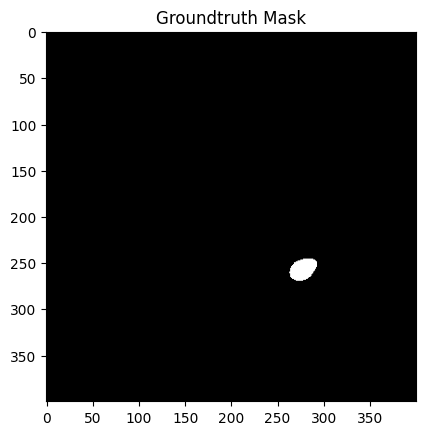

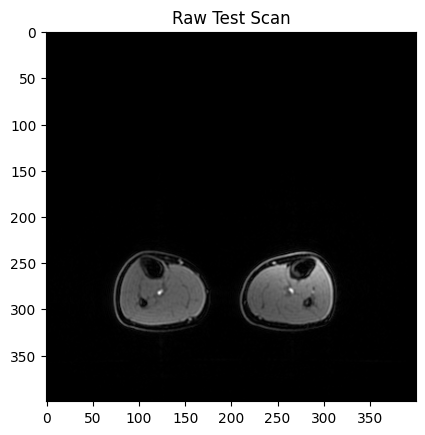

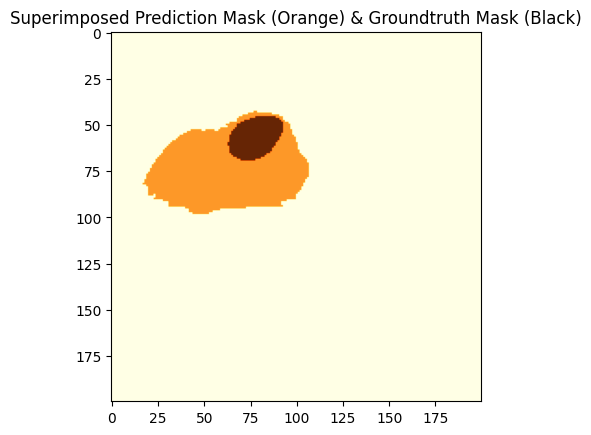

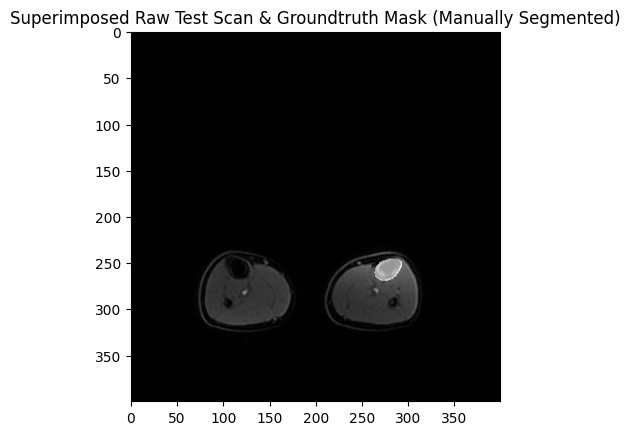

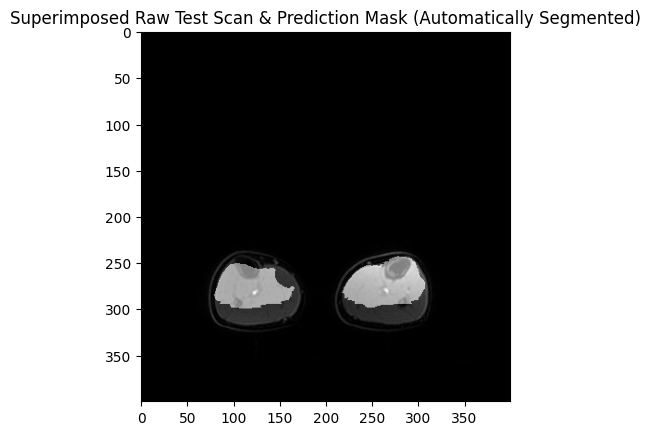

In [9]:
# model = 'model(Baseline 125 Epoch).h5'
# model = 'D:/MRI - Tairawhiti/Trained Models/model(2D UNet, 9 Patients, Tibia).h5'
# model = 'D:/MRI - Tairawhiti/Trained Models/model(2D UNet, 9 Patients, Tibia).h5'
# model = 'D:/MRI - Tairawhiti/Trained Models/H-DenseUNet.h5'
model = 'D:/MRI - Tairawhiti/Trained Models/model(2D-UNet, 3 Patients, Tibia, 400x400x1, 60 epoches).h5'
pred_img_idx = 50
MaskStack2D = False

from writeout_dataset import ReadInDatasets, ReadInDatasetNPY
# imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)', 0, 10)
# imgs_test_masks = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Masks_Tibia(Collab Sample)', 0, 10)
imgs_test = ReadInDatasetNPY('D:/MRI - Tairawhiti/Test_Data_Tibia(Collab Sample)')
imgs_test_masks = ReadInDatasetNPY('D:/MRI - Tairawhiti/Test_Masks_Tibia(Collab Sample)')

# imgs_test_masks = (imgs_test_masks > 0).astype(np.uint8)
# testing_scans_processed = np.reshape(imgs_test, (len(imgs_test), 512, 512, 1))
# testing_masks_processed = np.reshape(imgs_test_masks, (len(imgs_test), 512, 512, 1))
print('imgs_test size (Scans): ', imgs_test.shape)
print('imgs_test_masks size (Masks): ', imgs_test_masks.shape)

def superimpose_images(image1, image2):
    # Normalize the image intensities
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    alpha = 0.5  # Opacity of raw scan
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

print('-'*30)
print(f'Prediction Made Using Weights From Model: {model}')
print('-'*30)

# Prediction
best_model = load_model(model)
prediction = best_model.predict(np.reshape(imgs_test[pred_img_idx], (1,imgs_test.shape[1],imgs_test.shape[2],1)))
print('Testing Image Input Shape: ',imgs_test[pred_img_idx].shape)
# print('Prediction Mask Shape: ', prediction.shape)
print('\n')

# Evaluation
rounded_array  = np.round(prediction, decimals=3)
binary_pred = np.where(rounded_array != 0, 1, 0)
DSC = dice_coefficient((np.reshape(imgs_test_masks[pred_img_idx], (1,imgs_test_masks.shape[1],imgs_test_masks.shape[2],1))), binary_pred)
print('Dice Similarity Coefficient (DSC) Metric Value for Specified Slice: ', DSC)

if (MaskStack2D == True):
  DSC_stack = []
  pred_stack = []
  for i in tqdm(range(len(imgs_test_masks)), desc="Evaluating DSC on Paitent Scan Stack"):
    prediction_patient = best_model.predict(np.reshape(imgs_test[i], (1,imgs_test.shape[1],imgs_test.shape[2],1)))
    rounded_array  = np.round(prediction_patient, decimals=3)
    binary_pred_patient = np.where(rounded_array != 0, 1, 0)
    pred_stack.append(binary_pred_patient)
    DSC_patient = dice_coefficient((np.reshape(imgs_test_masks[i], (1,imgs_test_masks.shape[1],imgs_test_masks.shape[2],1))), binary_pred_patient)
    DSC_stack.append(DSC_patient)
  print('Average Dice Similarity Coefficient (DSC) Metric Value for Patient Scan Stack: ', np.mean(DSC_stack))
  np.save('ManualSegStack.npy', DSC_stack)
  print('\n')

# Visualisations
cmap_binary = 'white'
cmap_segmask = plt.cm.colors.ListedColormap(['black', cmap_binary])
bounds = [0, 0.5, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap_segmask.N)
fig, ax = plt.subplots()
ax.imshow(binary_pred[0, :, :, 0], cmap=cmap_segmask, norm=norm)
ax.axis('on')
plt.title('Model Outputted Segmentation Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(imgs_test_masks[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Groundtruth Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(imgs_test[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Test Scan')
plt.show()

cmap_binary = 'YlOrBr'
superimposed_image = superimpose_images(imgs_test_masks[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
# Define the cropping ranges
x_start, x_end = 200, 400
y_start, y_end = 200, 400
cropped_image = superimposed_image[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots()
cmap_superimposed = plt.cm.get_cmap(cmap_binary)
ax.imshow(cropped_image, cmap=cmap_superimposed, vmin=0, vmax=1)
ax.axis('on')
plt.title('Superimposed Prediction Mask (Orange) & Groundtruth Mask (Black)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(imgs_test[pred_img_idx, :, :, 0], imgs_test_masks[pred_img_idx, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Groundtruth Mask (Manually Segmented)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(imgs_test[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Prediction Mask (Automatically Segmented)')
plt.show()

Evaluation Metrics

In [88]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)

    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")

    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise

    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)

    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))

    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing

    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error

predictions_single_scan_binarized = np.reshape(predictions_single_scan_binarized,(1, 512, 512, 1))
DSC = dice_coefficient(testing_masks_processed, predictions_single_scan_binarized)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [4.0989216e-06]


